# How to run a homography

This notebook describes how to run a homography (i.e., map a point from one coordinate system to another coordinate system) using a set of shared points. This particular example uses the makerspace in Gutman 320. 

## Libraries

In [6]:
import os
import re
import io
import cv2
import sys
import csv
import time
import json
import math
import random
import IPython
import zipfile
import datetime
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import spatial
from PIL import Image, ImageDraw
from math import acos, degrees
from IPython.core.display import HTML
from PIL import Image, ImageDraw, ImageFont

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [62]:
# Check current working directory
os.getcwd()

'/content'

## Helpers

###Helpers for reading in files

In [0]:
def import_files(directory_in):
  
  files = []

  for file in os.listdir(directory_in):
      if file.endswith('.csv'):
          files.append(file)

  files.sort()

  return(files)

### Helpers for Plotting

In [0]:
# we plot all of our graphs inline
%matplotlib inline

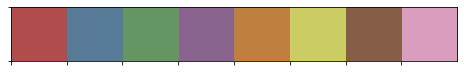

In [19]:
# we get a nice looking color palette from seaborn
sns.palplot(sns.color_palette("Set1", n_colors=8, desat=.5))

In [20]:
# we save the colors as RGB values
colors = sns.color_palette("Set1", n_colors=8, desat=.5)
print(colors)
#0.5343137254901962

[(0.696078431372549, 0.30000000000000004, 0.30392156862745096), (0.34215686274509804, 0.4813725490196079, 0.5950980392156863), (0.3950980392156863, 0.5872549019607843, 0.38921568627450986), (0.5343137254901962, 0.38921568627450975, 0.5558823529411765), (0.75, 0.49901960784313726, 0.25), (0.8, 0.8, 0.3999999999999999), (0.5274509803921569, 0.37058823529411766, 0.2803921568627451), (0.8529411764705883, 0.6215686274509804, 0.7431372549019608)]


In [0]:
# This helper function generates a new color and stores it in a dictionary
def random_color():
    r = lambda: random.randint(0,255)
    return [r(),r(),r()]

def get_color_for_id(entityId, dic):
    ''' Generates a color for a sensorID and saves it in a dictionary '''
    # we don't have a color for this entityId
    if entityId not in dic.keys():
        # we generate a new color for this entityId
        color = random_color()
        while color in dic.values():
            color = random_color()
        dic[entityId] = color
    # we return the result
    return dic[entityId]

dic_colors = {}


### Helpers for the Homography

In [0]:
def flatten(l):
    ''' flattens a list of lists '''
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

In [0]:
def do_homography(src_pts, dst_pts, src_point):
    ''' performs an homography for a new point given two lists of shared points 

    Args:
        src_pts (list of tuples): coordinates in the source coordinate system
        dst_pts (list of tuples): coordinates in the destination coordinate system
        src_point (tuple): x,y point in the source coordinate system

    Returns:
        dst_point: x,y point in the destination coordinate system'''
    
    # flatten those lists
    src_pts = list(flatten(src_pts))
    dst_pts = list(flatten(dst_pts))
    
    # convert points to numpy arrays
    src = [[src_pts[0+i*2],src_pts[1+i*2]] for i in range(len(src_pts)//2)]
    dst = [[dst_pts[0+i*2],dst_pts[1+i*2]] for i in range(len(dst_pts)//2)]
    
    # convert to float32
    src_pts = np.float32(src) 
    dst_pts = np.float32(dst)
    
    # pass those parameters to do the homography
    try: 
        M,mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        
        # find the location of the second gaze
        pts = np.float32(src_point).reshape(-1,1,2)
        point2_transformed = cv2.perspectiveTransform(pts,M)
        dst_point = point2_transformed[0][0]
        # return results
        return dst_point
    except:
        print("Unexpected error:", sys.exc_info())

In [0]:
def do_homography(src_pts, dst_pts, src_point):
    ''' performs an homography for a new point given two lists of shared points 

    Args:
        src_pts (list of tuples): coordinates in the source coordinate system
        dst_pts (list of tuples): coordinates in the destination coordinate system
        src_point (tuple): x,y point in the source coordinate system

    Returns:
        dst_point: x,y point in the destination coordinate system'''
    
    # flatten those lists
    src_pts = list(flatten(src_pts))
    dst_pts = list(flatten(dst_pts))
    
    # convert points to numpy arrays
    src = [[src_pts[0+i*2],src_pts[1+i*2]] for i in range(len(src_pts)//2)]
    dst = [[dst_pts[0+i*2],dst_pts[1+i*2]] for i in range(len(dst_pts)//2)]
    
    # convert to float32
    src_pts = np.float32(src) 
    dst_pts = np.float32(dst)
    
    # pass those parameters to do the homography
    try: 
        M,mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        #print(M)
        matchesMask = mask.ravel().tolist()
        # find the location of the second gaze
        pts = np.float32(src_point).reshape(-1,1,2)
        point2_transformed = cv2.perspectiveTransform(pts,M)
        dst_point = point2_transformed[0][0]
        # return results
        print('!!!', dst_point, type(dst_point))
        return dst_point

    except:
        print("Unexpected error:", sys.exc_info())

#testing = add_homography_to_current_df(directory_in, files[0], 'Head_x', 'Head_z', './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Homography Data', save = False)
#testing

# Get the data

### Calibration data

In [0]:
# folder where we can get the data
calibration_folder = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/Homography_Example/calibration/'
EISfloorplan = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/Homography_Example/images/EIS-floorplan.png'
data_folder = "./drive/Shared drives/2018-Makerspace-Personalization/Analyses/Homography_Example/data/"
##calibration_folder = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Cleaned Data/All_calibrations'
#EISfloorplan = './drive/Shared drives/2018-Makerspace-Personalization/Data/Kinect Data/2019-02-Week1/lab-floorplan/EIS-floorplan.png'
#data_folder = "./drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Cleaned Data"


In [0]:
KINECT_IDS = ["003455463847",
              "009581564747", 
              "003406163847", 
              "002467263847", 
              "001904763747", 
              "002949463847"]

In [15]:
# df for testing out code
df = pd.read_csv('./drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Cleaned Data/2019-02-14.csv')
df.head()

# all data
directory_in = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Cleaned Data/'
files = import_files(directory_in)
files.remove('df_names.csv')
print(files)

['2019-02-14.csv', '2019-02-15.csv', '2019-02-16.csv', '2019-02-18.csv', '2019-02-19.csv', '2019-02-20.csv', '2019-02-21.csv', '2019-02-22.csv', '2019-02-23.csv', '2019-02-25.csv', '2019-02-26.csv', '2019-02-27.csv', '2019-02-28.csv', '2019-03-01.csv', '2019-03-02.csv', '2019-03-03.csv', '2019-03-04.csv', '2019-03-05.csv', '2019-03-06.csv', '2019-03-07.csv', '2019-03-08.csv', '2019-03-10.csv', '2019-03-11.csv', '2019-03-12.csv', '2019-03-13.csv', '2019-03-14.csv', '2019-03-15.csv', '2019-03-16.csv', '2019-03-19.csv', '2019-03-20.csv', '2019-03-21.csv', '2019-03-22.csv', '2019-03-23.csv', '2019-03-25.csv', '2019-03-26.csv', '2019-03-27.csv', '2019-03-28.csv', '2019-03-29.csv', '2019-03-30.csv', '2019-03-31.csv', '2019-04-01.csv', '2019-04-02.csv', '2019-04-03.csv', '2019-04-04.csv', '2019-04-05.csv', '2019-04-06.csv', '2019-04-07.csv', '2019-04-08.csv', '2019-04-09.csv', '2019-04-10.csv', '2019-04-11.csv', '2019-04-12.csv', '2019-04-14.csv', '2019-04-15.csv', '2019-04-16.csv', '2019-04-

In [16]:
def get_calibration_file(kinect_id):
    for txt_file in os.listdir(calibration_folder):
        if kinect_id in txt_file and txt_file.endswith('.txt'):
            return os.path.join(calibration_folder, txt_file)
    return None

get_calibration_file("002467263847")

'./drive/Shared drives/2018-Makerspace-Personalization/Analyses/Homography_Example/calibration/002467263847_2019-04-25_12-12-13.txt'

In [0]:
def get_calibration_for_kinect(kinect_id):
    
    # get the calibration file
    calibration_file = get_calibration_file(kinect_id)
    
    # save coordinates here
    x_kinect,y_kinect = [],[]
    x_plan,y_plan = [],[]
    kinect, plan = [],[]
    
    # iterate through the data
    with open(calibration_file, "r") as f:
        for line in f:
            values = [float(x) for x in line.replace('\n','').split(',')]
            x_plan.append(values[0])
            y_plan.append(values[1])
            x_kinect.append(values[2])
            y_kinect.append(values[3])
            
            ## debug homography
            kinect.append((values[2], values[3]))
            plan.append((values[0], values[1]))
            
    return x_kinect,y_kinect,x_plan,y_plan, kinect, plan

In [18]:
def create_dictionary_of_calibration(KINECT_IDS):
    
    dic = {}
    
    for kinect_id in KINECT_IDS:
        
        dic[kinect_id] = {}
        
        # get the calibration dots
        x_kinect,y_kinect,x_plan,y_plan, kinect, plan = get_calibration_for_kinect(kinect_id)
        
        # debug homography
        dic[kinect_id]['src'] = kinect
        dic[kinect_id]['dst'] = plan
    # return the results
    return dic

calibration = create_dictionary_of_calibration(KINECT_IDS)
print(calibration[KINECT_IDS[0]])

{'src': [(-1.623135625, 2.542198875), (-1.1463686333333334, 2.1033473333333332), (-0.6977109333333333, 1.5890056666666668), (-1.1313545, 2.8752175555555555), (-0.6923081, 2.429921), (-0.274540035, 1.9891253), (-0.8008786777777778, 3.2664916666666666), (-0.320887113, 2.8173715), (0.046820635454545456, 2.419333181818182)], 'dst': [(840.0, 255.0), (895.0, 255.0), (950.0, 255.0), (840.0, 310.0), (895.0, 310.0), (950.0, 310.0), (840.0, 365.0), (895.0, 365.0), (950.0, 365.0)]}


In [33]:
type(calibration)
len(calibration)
#pts = calibration[KINECT_IDS[0]]['src']
#list(flatten(pts))


scrs = []
dsts = []

for i in calibration.keys():
  src_pts = calibration[i]['src']
  dst_pts = calibration[i]['dst']

  src_pts = list(flatten(src_pts))
  dst_pts = list(flatten(dst_pts))
    
    # convert points to numpy arrays
  src = [[src_pts[0+i*2],src_pts[1+i*2]] for i in range(len(src_pts)//2)]
  dst = [[dst_pts[0+i*2],dst_pts[1+i*2]] for i in range(len(dst_pts)//2)]
    
    # convert to float32
  src_pts = np.float32(src) 
  dst_pts = np.float32(dst)

  #print(i, ':', src_pts)
  print(i)
  scrs.append(','.join([str(i) for i in list(flatten(src_pts))]))
  dsts.append(','.join([str(i) for i in list(flatten(dst_pts))]))
  #dst_pts



003455463847
009581564747
003406163847
002467263847
001904763747
002949463847


In [0]:

ki = ["3455463847", "9581564747", "3406163847", "2467263847", "1904763747", "2949463847"]
d = {'kinect_id': ki, 'src': scrs, 'dst': dsts}
df_calibration = pd.DataFrame(d)
df_calibration.to_csv('./drive/My Drive/Colab Notebooks/calibration.csv')


## Plot data on the floor plan 

array([[ 0.8201674 ,  2.3729331 ],
       [ 0.39405075,  2.8133454 ],
       [-0.06887855,  3.1495876 ],
       [ 0.34753805,  1.9503893 ],
       [-0.03872221,  2.3041048 ],
       [-0.4680561 ,  2.7073383 ],
       [ 0.04990216,  1.481983  ],
       [-0.4166564 ,  1.9192586 ],
       [-0.8852856 ,  2.3040912 ]], dtype=float32)

KeyboardInterrupt: ignored

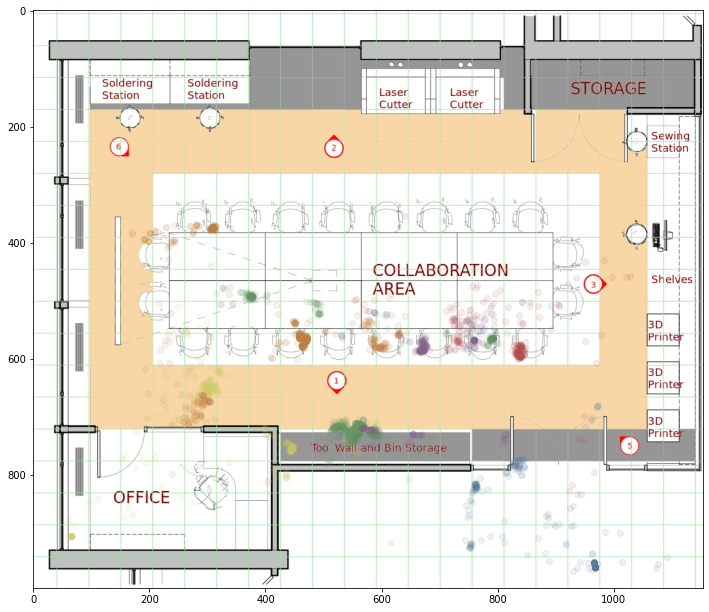

In [31]:
# load the image
floorplan = Image.open(EISfloorplan)
im_array = np.asarray(floorplan)

time1 = time.time()

# creat the graph
plt.figure(figsize=(12,16))
plt.imshow(im_array)

# do the homography for each point of a subset of the data
for index,row in df.iterrows():
    
    #if row['kinect_id'] != 9581564747 and row['kinect_id'] != 2949463847:

    # get info on the kinect 
    kID = '00' + str(int(row['kinect_id']))
    #print(kID)
    color = colors[KINECT_IDS.index(kID)]
    #print(color)
    src_pts,dst_pts = calibration[kID]['src'],calibration[kID]['dst']
    #print(src_pts, dst_pts)
    
    # do the homography and plot the results
    result = do_homography(src_pts, dst_pts, (row['Head_x'], row['Head_z']))
    plt.plot(result[0], result[1]+200, 'o', color=color, alpha=0.1)
    
    # we only plot 3000 points as an example
    if index > 3000: break
      
# function 
print('everything took %i sec' % ((time.time()-time1)))
        
plt.show()

In [44]:
print(KINECT_IDS[0])
calibration[KINECT_IDS[0]]
len(calibration[KINECT_IDS[0]]['src'])
calibration

003455463847


{'001904763747': {'dst': [(235.0, 255.0),
   (290.0, 255.0),
   (345.0, 255.0),
   (235.0, 310.0),
   (290.0, 310.0),
   (345.0, 310.0),
   (235.0, 365.0),
   (290.0, 365.0),
   (345.0, 365.0)],
  'src': [(-0.10816508818181818, 1.7226750909090909),
   (0.32616724571428574, 2.234669285714286),
   (0.4897911846153846, 2.3670403846153847),
   (-0.5593591428571428, 2.2618092857142855),
   (-0.0504379801, 2.6665931),
   (0.3603193571428571, 3.0429945714285713),
   (-0.9526145111111111, 2.7089724444444445),
   (-0.9439305444444445, 2.718903666666667),
   (-0.016546551083333333, 3.44139875)]},
 '002467263847': {'dst': [(565.0, 255.0),
   (620.0, 255.0),
   (675.0, 255.0),
   (565.0, 310.0),
   (620.0, 310.0),
   (675.0, 310.0),
   (565.0, 365.0),
   (620.0, 365.0),
   (675.0, 365.0)],
  'src': [(-0.7884055857142858, 1.3544108571428572),
   (-0.36353548888888887, 1.387021888888889),
   (0.240302511, 1.4589421),
   (-1.02552687, 2.0074306),
   (-0.43001652307692306, 2.049922),
   (0.17410059057

In [38]:

directory = directory_in
filename =  files[0]
df = pd.read_csv(os.path.join(directory + filename))



,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,HandRight_z,HandRight_isInferred,FootLeft_x,FootLeft_y,FootLeft_z,FootLeft_isInferred,FootRight_x,FootRight_y,FootRight_z,FootRight_isInferred,KneeLeft_x,KneeLeft_y,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name
0,7289,2019-02-14 06:09:02,9729879,9581564747,72057594037930580,NaN,NaN,grey,0.000,False,False,False,False,False,1.256376,0.136456,0.147472,1.490122,False,-0.074243,-0.049569,1.523453,False,0.287621,-0.038925,1.610420,False,-0.184977,-0.301620,1.690245,False,0.373256,-0.236861,1.737787,False,-0.175380,-0.561002,1.643222,False,0.665506,...,1.375846,False,0.655110,-0.097225,1.492196,False,0.412674,-0.878479,1.591349,False,0.502498,-0.470183,1.550077,False,0.603073,-0.462641,1.537921,False,0.778141,0.010167,1.531455,True,0.561419,-0.863608,1.562376,False,-0.006735,-0.521039,1.562159,False,0.155231,-0.523326,1.599779,False,0.244744,0.191110,128.103.181.53,i3,0.44,NaN
1,7290,2019-02-14 06:09:04,8329262,9581564747,72057594037930580,NaN,NaN,grey,101.249,False,False,False,False,True,1.413870,0.002692,0.067774,1.219708,False,-0.197450,-0.119114,1.283759,False,0.146586,-0.058552,1.420195,False,-0.312723,-0.312580,1.298417,False,0.312283,-0.183737,1.626933,False,-0.304710,-0.541231,1.140858,True,0.665086,...,1.370701,False,0.326101,-1.107603,1.415674,True,0.516989,-0.735779,1.439523,False,0.119612,-0.778775,1.481493,False,0.496757,-0.463362,1.544110,False,0.292147,-1.054301,1.526168,True,0.505121,-0.838551,1.510885,True,-0.082577,-0.466933,1.456384,False,0.061064,-0.455887,1.498101,False,-0.087747,0.119718,128.103.181.53,i3,0.44,NaN
2,7291,2019-02-14 06:09:12,9265421,9581564747,72057594037930580,NaN,NaN,grey,44.309,False,False,False,True,False,1.340613,0.608696,0.710797,1.499695,False,0.519722,0.507548,1.526836,False,0.820327,0.572462,1.609153,True,0.680990,0.534408,1.328899,False,0.918454,0.282885,1.616867,True,0.811691,0.643750,1.159998,True,1.047528,...,1.679917,False,0.509806,-0.669311,1.468647,False,0.928768,-0.225305,1.744045,False,0.481679,-0.443300,1.533851,False,0.942773,-0.506828,1.703628,False,0.481474,-0.816405,1.499762,False,0.941409,-0.090334,1.771261,True,0.703092,-0.112037,1.693653,False,0.817651,-0.077622,1.679204,False,-0.147706,0.501803,128.103.181.53,i3,0.44,NaN
3,7292,2019-02-14 06:09:14,6237735,9581564747,72057594037930580,NaN,NaN,grey,18.270,False,False,False,True,False,1.340613,0.625466,0.712613,1.488644,False,0.551187,0.587083,1.501953,False,0.818583,0.570953,1.607239,True,0.693686,0.533214,1.316412,False,0.932152,0.292573,1.623960,True,0.871236,0.720112,1.085912,True,1.141146,...,1.857498,True,0.498728,-0.868189,1.392615,True,0.507478,-0.661213,1.602576,False,0.484224,-0.449944,1.537460,False,0.491843,-0.356680,1.532216,False,0.474211,-0.813821,1.511215,False,0.385920,-0.658675,1.593169,True,0.541576,-0.011859,1.474451,False,0.627752,-0.011245,1.820394,False,0.394838,0.250134,128.103.181.53,i3,0.44,NaN
4,7293,2019-02-14 06:09:16,2498720,9581564747,72057594037930580,NaN,NaN,grey,52.539,False,False,False,False,True,-1.342919,1.255889,-0.180068,2.225606,False,0.581315,0.623630,1.468904,False,1.221652,-0.431817,2.150108,False,0.742396,0.603103,1.

In [0]:
# Function for converting current data

def add_homography_to_current_df(directory, filename, location_1, location_2, destination_folder, save = True): 
  '''performs an homography for given locations given a csv file.

  Args:
  directory: string, directory of csv file
  filename: string, name of kinect csv file
  location_1, location_2: string, location to convert, column name (e.g. 'Head_x', 'Head_z'), 
  destination_folder: string, full path of folder to save new df as csv file into, if save = True

  Returns:
  if save = True, saves a new df with into the destination folder as a csv file and returns None.
  if save = False, returns new df'''


  df = pd.read_csv(os.path.join(directory + filename))
  loc1_homography = np.zeros(len(df))
  loc2_homography = np.zeros(len(df))

  for index,row in df.iterrows():
    kID = '00' + str(int(row['kinect_id']))
    src_pts,dst_pts = calibration[kID]['src'],calibration[kID]['dst']
    result = do_homography(src_pts, dst_pts, (row[location_1], row[location_2]))
    
    #results.append(result)
    loc1_homography[index] = result[0]
    loc2_homography[index] = result[1]
  
  df[location_1 + '_homography'] = loc1_homography 
  df[location_2 + '_homography'] = loc2_homography
  
  if save:
    df.to_csv(os.path.join(destination_folder, filename))
    print('finished saving', filename)

  else:
    return df


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

TypeError: ignored

In [0]:
for f in files:
  add_homography_to_current_df(directory_in, f, 'Head_x', 'Head_z', './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Homography Data')

finished saving 2019-02-14.csv
finished saving 2019-02-15.csv
finished saving 2019-02-16.csv
finished saving 2019-02-18.csv
finished saving 2019-02-19.csv
finished saving 2019-02-20.csv
finished saving 2019-02-21.csv
finished saving 2019-02-22.csv
finished saving 2019-02-23.csv
finished saving 2019-02-25.csv
finished saving 2019-02-26.csv
finished saving 2019-02-27.csv
finished saving 2019-02-28.csv
finished saving 2019-03-01.csv
finished saving 2019-03-02.csv
finished saving 2019-03-03.csv
finished saving 2019-03-04.csv
finished saving 2019-03-05.csv
finished saving 2019-03-06.csv
finished saving 2019-03-07.csv
finished saving 2019-03-08.csv
finished saving 2019-03-10.csv
finished saving 2019-03-11.csv
finished saving 2019-03-12.csv
finished saving 2019-03-13.csv
finished saving 2019-03-14.csv
finished saving 2019-03-15.csv
finished saving 2019-03-16.csv
finished saving 2019-03-19.csv
finished saving 2019-03-20.csv
finished saving 2019-03-21.csv
finished saving 2019-03-22.csv
finished

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


finished saving 2019-03-27.csv
finished saving 2019-03-28.csv
finished saving 2019-03-29.csv
finished saving 2019-03-30.csv
finished saving 2019-03-31.csv
finished saving 2019-04-01.csv
finished saving 2019-04-02.csv
finished saving 2019-04-03.csv
finished saving 2019-04-04.csv
finished saving 2019-04-05.csv
finished saving 2019-04-06.csv
finished saving 2019-04-07.csv
finished saving 2019-04-08.csv
finished saving 2019-04-09.csv
finished saving 2019-04-10.csv
finished saving 2019-04-11.csv
finished saving 2019-04-12.csv
finished saving 2019-04-14.csv
finished saving 2019-04-15.csv
finished saving 2019-04-16.csv
finished saving 2019-04-17.csv
finished saving 2019-04-18.csv
finished saving 2019-04-19.csv
finished saving 2019-04-20.csv
finished saving 2019-04-21.csv
finished saving 2019-04-22.csv
finished saving 2019-04-23.csv
finished saving 2019-04-24.csv
finished saving 2019-04-25.csv
finished saving 2019-04-26.csv
finished saving 2019-04-27.csv
finished saving 2019-04-28.csv
finished

In [0]:
testing

,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,FootLeft_x,FootLeft_y,FootLeft_z,FootLeft_isInferred,FootRight_x,FootRight_y,FootRight_z,FootRight_isInferred,KneeLeft_x,KneeLeft_y,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name,Head_x_homography,Head_z_homography
0,7289,2019-02-14 06:09:02,9729879,9581564747,72057594037930580,NaN,NaN,grey,0.000,False,False,False,False,False,1.256376,0.136456,0.147472,1.490122,False,-0.074243,-0.049569,1.523453,False,0.287621,-0.038925,1.610420,False,-0.184977,-0.301620,1.690245,False,0.373256,-0.236861,1.737787,False,-0.175380,-0.561002,1.643222,False,0.665506,...,0.655110,-0.097225,1.492196,False,0.412674,-0.878479,1.591349,False,0.502498,-0.470183,1.550077,False,0.603073,-0.462641,1.537921,False,0.778141,0.010167,1.531455,True,0.561419,-0.863608,1.562376,False,-0.006735,-0.521039,1.562159,False,0.155231,-0.523326,1.599779,False,0.244744,0.191110,128.103.181.53,i3,0.44,NaN,984.720215,698.348328
1,7290,2019-02-14 06:09:04,8329262,9581564747,72057594037930580,NaN,NaN,grey,101.249,False,False,False,False,True,1.413870,0.002692,0.067774,1.219708,False,-0.197450,-0.119114,1.283759,False,0.146586,-0.058552,1.420195,False,-0.312723,-0.312580,1.298417,False,0.312283,-0.183737,1.626933,False,-0.304710,-0.541231,1.140858,True,0.665086,...,0.326101,-1.107603,1.415674,True,0.516989,-0.735779,1.439523,False,0.119612,-0.778775,1.481493,False,0.496757,-0.463362,1.544110,False,0.292147,-1.054301,1.526168,True,0.505121,-0.838551,1.510885,True,-0.082577,-0.466933,1.456384,False,0.061064,-0.455887,1.498101,False,-0.087747,0.119718,128.103.181.53,i3,0.44,NaN,1010.164185,700.437073
2,7291,2019-02-14 06:09:12,9265421,9581564747,72057594037930580,NaN,NaN,grey,44.309,False,False,False,True,False,1.340613,0.608696,0.710797,1.499695,False,0.519722,0.507548,1.526836,False,0.820327,0.572462,1.609153,True,0.680990,0.534408,1.328899,False,0.918454,0.282885,1.616867,True,0.811691,0.643750,1.159998,True,1.047528,...,0.509806,-0.669311,1.468647,False,0.928768,-0.225305,1.744045,False,0.481679,-0.443300,1.533851,False,0.942773,-0.506828,1.703628,False,0.481474,-0.816405,1.499762,False,0.941409,-0.090334,1.771261,True,0.703092,-0.112037,1.693653,False,0.817651,-0.077622,1.679204,False,-0.147706,0.501803,128.103.181.53,i3,0.44,NaN,962.739624,734.199524
3,7292,2019-02-14 06:09:14,6237735,9581564747,72057594037930580,NaN,NaN,grey,18.270,False,False,False,True,False,1.340613,0.625466,0.712613,1.488644,False,0.551187,0.587083,1.501953,False,0.818583,0.570953,1.607239,True,0.693686,0.533214,1.316412,False,0.932152,0.292573,1.623960,True,0.871236,0.720112,1.085912,True,1.141146,...,0.498728,-0.868189,1.392615,True,0.507478,-0.661213,1.602576,False,0.484224,-0.449944,1.537460,False,0.491843,-0.356680,1.532216,False,0.474211,-0.813821,1.511215,False,0.385920,-0.658675,1.593169,True,0.541576,-0.011859,1.474451,False,0.627752,-0.011245,1.820394,False,0.394838,0.250134,128.103.181.53,i3,0.44,NaN,962.749512,735.958679
4,7293,2019-02-14 06:09:16,2498720,9581564747,72057594037930580,NaN,NaN,grey,52.539,False,False,False,False,True,-1.342919,1.255889,-0.180068,2.225606,False,0.581315,0.623630,1.468904,False,1.221652,-0.431817,2.

,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,HandRight_isInferred,FootLeft_x,FootLeft_y,FootLeft_z,FootLeft_isInferred,FootRight_x,FootRight_y,FootRight_z,FootRight_isInferred,KneeLeft_x,KneeLeft_y,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name,head_x_homography
0,2473,2019-02-15 00:41:48,9137614,9581564747,72057594037948842,NaN,NaN,grey,0.000,False,False,False,False,False,1.262750,0.909990,0.163146,1.860968,False,0.700514,-0.048270,1.767604,False,0.877182,-0.080572,1.650870,False,0.764375,-0.226325,1.589899,False,0.807490,-0.300879,1.546237,False,0.826128,-0.511288,1.543761,True,0.879572,...,True,0.486534,-0.995706,1.760769,False,0.361311,-0.899738,1.638227,False,0.578806,-0.796733,1.764409,False,0.799028,-0.768527,1.652057,False,0.431769,-1.036246,1.860082,False,0.424910,-0.869202,1.755301,True,0.671388,-0.505327,1.744648,False,0.745486,-0.519097,1.685237,False,0.709798,-0.779191,128.103.181.53,i4,1.0,NaN,926.097473
1,3952,2019-02-15 06:18:36,3010423,1904763747,72057594037959379,NaN,NaN,purple,363.117,True,False,False,False,False,-1.557129,-1.367954,0.086754,3.170274,False,-1.521647,-0.087554,3.124475,False,-1.225523,-0.088165,3.276640,False,-1.637390,-0.155009,3.050616,False,-1.161900,-0.285482,3.265097,False,-1.308473,-0.175310,3.182387,True,-1.114260,...,False,-1.092720,-1.079634,2.432824,False,-1.033203,-1.160156,2.542969,False,-1.329234,-0.559599,2.862793,False,-1.138357,-0.604762,2.990478,False,-1.146927,-1.027497,2.538637,False,-0.970205,-1.076800,2.605638,False,-1.535761,-0.479959,3.297592,False,-1.410646,-0.470530,3.370357,False,0.081234,1.000000,128.103.181.96,i4,none,NaN,233.234329
2,3958,2019-02-15 06:18:57,4232510,9581564747,72057594037948842,NaN,NaN,grey,0.000,False,False,False,False,False,1.262750,-2.736046,0.086960,4.183113,False,-2.810448,0.046958,4.097586,False,-2.600070,-0.101734,4.172709,False,-2.789613,-0.144045,4.079392,False,-2.556203,-0.271916,4.134688,False,-2.786621,0.124351,4.120844,False,-2.529738,...,False,-2.669331,-0.524903,3.497969,True,-2.296146,-0.767805,3.811229,True,-2.750949,-0.432655,3.930397,True,-2.533117,-0.428013,4.069755,False,-2.689037,-0.465346,3.594881,True,-2.313518,-0.709539,3.909497,False,-2.826313,-0.399858,4.298064,False,-2.731264,-0.467094,4.325972,False,0.047441,0.731068,128.103.181.53,i4,1.0,NaN,922.097534
3,3959,2019-02-15 06:18:58,9194368,9581564747,72057594037948842,NaN,NaN,grey,441.195,False,False,False,False,False,1.262750,-2.332016,0.227745,3.498563,False,-2.363074,0.070277,3.471750,False,-2.234912,0.071995,3.599489,False,-2.341056,-0.115261,3.419277,False,-2.159314,-0.085141,3.591820,False,-2.325711,-0.321020,3.430227,True,-2.095010,...,False,-2.363931,-0.420343,3.374076,True,-2.061217,-0.382445,3.470462,False,-2.312811,-0.426276,3.484432,False,-2.049864,-0.298414,3.566404,False,-2.430752,-0.458372,3.328220,True,-2.059749,-0.473350,3.473276,False,-2.324266,-0.206751,3.500421,False,-2.259144,-0.206658,3.543799,False,0.089197,0.912670,128.103.181.53,i4,1.0,NaN,955.916016
4,3960,2019-02-15 06:19:00,5069853,9581564747,72057594037949833,NaN,NaN,grey,142.599,False,False,False,False,False,1.450284,-1.226266,0.204423,2.603020,False,-1.387856,0.049085,2.52

In [0]:
# im_array is approx, 1000 to 1200.
set(df.kinect_id)

{1904763747, 2467263847, 2949463847, 3406163847, 3455463847, 9581564747}

In [0]:
add_homography_to_current_df('./drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Toy Data/', 'Non class time 2019-04-26.csv', 'Head_x', 'Head_z', './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Homography Data')
sample = add_homography_to_current_df('./drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Toy Data/', 'Non class time 2019-04-26.csv', 'Head_x', 'Head_z', './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Homography Data', save = False) 

finished saving Non class time 2019-04-26.csv


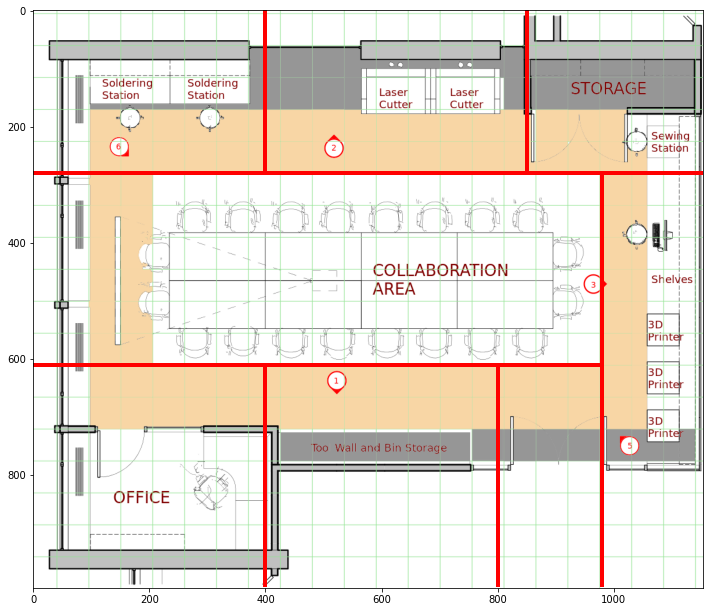

In [0]:
# These are the numbers I use to divide the space into workstations

floorplan = Image.open(EISfloorplan)
im_array = np.asarray(floorplan)
plt.figure(figsize=(12,16))
plt.imshow(im_array)

xt1 = 400 
xt2 = 850
xb1 = 400
xb2 = 800
xb3 = 980

y1 = 280
y2 = 610

plt.axhline(y1, color = 'red', linewidth = 4)
#plt.axhline(y2, color = 'red', linewidth = 4)
plt.plot((0,xb3), (y2, y2),  color = 'red', linewidth = 4)
plt.plot((xt1, xt1), (0, y1), color = 'red', linewidth = 4)
plt.plot((xt2, xt2), (0, y1), color = 'red', linewidth = 4)
plt.plot((xb1, xb1), (y2, 990), color = 'red', linewidth = 4)
plt.plot((xb2, xb2), (y2, 990), color = 'red', linewidth = 4)
plt.plot((xb3, xb3), (y1, 990), color = 'red', linewidth = 4)

In [0]:

def get_station_location(df):
  '''
  Calculates the location of a datapoint, classifies it into workstations
  '''
  # initialize new columns (np arrays)
  is_at_soldering = np.zeros(len(sample))
  is_at_laserCutter = np.zeros(len(sample))
  is_at_3d = np.zeros(len(sample))
  is_at_toolWall = np.zeros(len(sample))
  is_at_sewing = np.zeros(len(sample))
  is_at_entrance = np.zeros(len(sample))
  is_at_office = np.zeros(len(sample))
  is_at_collab = np.zeros(len(sample))
#  is_just_studying = np.zeros(len(sample))

  # define 'cutting points' in grid
  xt1 = 400 
  xt2 = 850
  xb1 = 400
  xb2 = 800
  xb3 = 980

  y1 = 280
  y2 = 610


  for index, row in sample.iterrows():
    x = row['Head_x_homography']
    y = row['Head_z_homography']
    #print(x, y)
    
    # Top 3 stations
    if x < xt1 and y < y1:
      is_at_soldering[index] = 1
    elif xt1 <= x < xt2 and y < y1:
      is_at_laserCutter[index] = 1
    elif x >= xt2 and y < y1:
      is_at_sewing[index] = 1
    
    # Bottom 3 slots
    elif x < xb1 and y >= y2:
      is_at_office[index] = 1
    elif xb1 <= x < xb2 and y >= y2:
      is_at_toolWall[index] = 1
    elif xb2 <= x < xb3 and y >= y2:
      is_at_entrance[index] = 1

    # 3d printer
    elif xb3 <= x and y >= y1:
      is_at_3d[index] = 1
   
    

    # collaborative space  
    else:
      is_at_collab[index] = 1

  df['is_at_soldering'] = is_at_soldering
  df['is_at_laserCutter'] = is_at_laserCutter
  df['is_at_3d'] = is_at_3d
  df['is_at_toolWall'] = is_at_toolWall
  df['is_at_sewing'] = is_at_sewing
  df['is_at_entrance'] = is_at_entrance
  df['is_at_office'] = is_at_office
  df['is_at_collab'] = is_at_collab
  df['is_just_studying'] = is_just_studying
  # Is at any of the work stations
  arr = [is_at_soldering, is_at_sewing, is_at_3d, is_at_laserCutter]
  #df['is_at_work_station'] = arr.sum(axis = 0)
  df['is_at_work_station'] = sum(arr)

  return df 

In [0]:
get_station_location(sample)

,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name,Head_x_homography,Head_z_homography,is_at_soldering,is_at_laserCutter,is_at_3d,is_at_toolWall,is_at_sewing,is_at_entrance,is_at_office,is_at_collab,is_just_studying,is_at_work_station
0,2329,4/26/19 14:00,6628675,9581564747,7.205760e+16,NaN,NaN,grey,6.079,True,False,False,False,True,1.476269,1.102220,-0.100400,4.520858,False,1.021471,-0.262023,4.409283,False,1.233785,-0.279612,4.464345,False,0.950283,-0.385617,4.357732,False,1.305359,-0.148969,4.407629,True,1.090683,-0.550422,4.394199,False,1.272083,...,4.496730,False,1.130204,-0.927889,4.540505,True,0.999687,-1.202438,4.508916,False,0.899312,-0.968982,4.428206,False,1.024872,-0.611131,4.466196,False,1.139404,-0.628635,4.481776,False,0.413244,-0.301487,128.103.181.53,none,none,NaN,754.955017,639.852783,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2330,4/26/19 14:00,139173,9581564747,7.205760e+16,NaN,NaN,grey,17.923,True,False,False,False,True,1.476269,1.327318,-0.027234,4.520749,False,1.138512,-0.172741,4.427680,False,1.356216,-0.245012,4.424701,False,1.052374,-0.337492,4.410307,False,1.450495,-0.244181,4.317276,False,1.117129,-0.555022,4.362836,False,1.363327,...,4.389203,False,1.118353,-0.972858,4.391205,False,1.085596,-1.278062,4.316303,False,1.095537,-1.277711,4.322960,False,1.098061,-0.594769,4.428370,False,1.186313,-0.616068,4.431616,False,0.482285,-0.254898,128.103.181.53,none,none,NaN,748.581848,656.345825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2331,4/26/19 14:00,7273741,9581564747,7.205760e+16,NaN,NaN,grey,17.923,False,False,False,False,False,-1.532132,1.191818,0.008660,3.872203,False,1.031352,-0.195410,3.910617,False,1.295771,-0.197882,3.767886,False,0.974566,-0.384130,3.970579,False,1.338912,-0.364722,3.705561,False,0.987469,-0.551532,3.895049,False,1.161960,...,3.855456,False,1.216088,-0.963049,3.852703,False,0.999127,-1.280377,3.874566,False,1.216324,-1.284128,3.905389,False,1.090550,-0.606955,3.881204,False,1.185624,-0.608925,3.792549,False,0.290034,0.072446,128.103.181.53,drew,1,NaN,790.695862,673.232910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2332,4/26/19 14:00,8032612,9581564747,7.205760e+16,NaN,NaN,grey,62.215,False,False,False,False,False,-0.919202,0.890090,0.007663,3.284063,False,0.763160,-0.109965,3.189512,False,0.956100,-0.198235,3.160755,False,0.752299,-0.259121,3.334551,False,1.072163,-0.362934,3.225179,False,0.717973,-0.573201,3.376679,False,1.110946,...,3.373106,False,0.882226,-0.959679,3.281735,False,0.815993,-1.294016,3.359873,False,0.890898,-1.265834,3.288204,False,0.796205,-0.590686,3.313723,False,0.914977,-0.593047,3.238326,False,0.212835,0.003103,128.103.181.53,drew,1,NaN,836.341309,675.897400,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2333,4/26/19 14:00,8350080,9581564747,7.205760e+16,NaN,NaN,grey,8.166,False,False,False,False,False,-1.278984,0.875366,0.003018,3.292193,False,0.743249,-0.206005,3.373389,False,0.930292,-0.210461,3.151278,False,0.717337,-0.404811,3.500460,False,1.092193,-0.417029,3.259470,False,0.718230,-0.607675,3.305251,False,0.978592,...,3.353863,False,0.859965,-0.956114,3.284333,False,0.818696,-1.262885,3.367986,False

In [0]:
sample[sample.is_at_collab == 1.0]

,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,KneeLeft_y,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name,Head_x_homography,Head_z_homography,is_at_soldering,is_at_laserCutter,is_at_3d,is_at_toolWall,is_at_sewing,is_at_entrance,is_at_office,is_at_collab,is_just_studying
6,2335,4/26/19 14:00,667414,2467263847,7.205760e+16,NaN,NaN,orange,0.000,False,False,False,False,False,0.000000,-0.365948,0.182957,4.324062,False,-0.563910,-0.037596,4.315154,False,-0.328511,-0.046800,4.483315,False,-0.717560,-0.251388,4.329761,False,-0.365568,0.154632,4.214786,True,-0.684115,-0.429076,4.079103,False,-0.219383,...,-0.805832,4.313155,False,-0.484347,-0.812911,4.370401,True,-0.635517,-1.062899,4.531456,False,-0.630142,-1.056550,4.567275,False,-0.580895,-0.485426,4.533914,False,-0.453844,-0.486809,4.577656,False,0.141885,0.898179,128.103.181.18,none,none,NaN,641.150574,528.200195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2336,4/26/19 14:00,2272565,2467263847,7.205760e+16,NaN,NaN,orange,305.658,False,False,False,False,False,1.422866,-0.190196,0.132022,4.436928,False,-0.424365,-0.007966,4.497889,False,-0.110061,-0.050557,4.507473,False,-0.564886,-0.188531,4.495478,False,-0.081264,-0.256557,4.392893,False,-0.499741,-0.423133,4.437805,True,-0.189696,...,-0.471292,4.312722,False,-0.023170,-0.190084,4.302041,False,-0.825620,-0.598261,4.207336,True,-0.410280,-0.474036,4.372383,True,-0.367832,-0.360085,4.553619,False,-0.171003,-0.359733,4.568841,False,0.303674,0.916417,128.103.181.18,none,none,NaN,660.050354,540.423096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2338,4/26/19 14:00,5459488,3406163847,7.205760e+16,NaN,NaN,green,0.000,False,True,False,True,True,0.997842,-0.351692,0.186189,2.737383,False,-0.396082,-0.088696,2.476011,False,-0.122303,0.013842,2.484384,False,-0.458087,-0.303901,2.532299,False,0.032746,-0.164748,2.489891,False,-0.522121,-0.512070,2.548550,True,0.192107,...,-0.854912,2.196926,False,0.046238,-0.846700,2.169698,False,-0.191750,-1.153221,2.187757,False,0.100935,-1.061457,2.013006,False,-0.171437,-0.549775,2.266293,False,-0.046404,-0.503093,2.262912,False,-0.409761,-0.854738,128.103.181.95,none,0,NaN,675.917297,500.061554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,2340,4/26/19 14:00,7157621,3406163847,7.205760e+16,NaN,NaN,green,163.112,False,True,False,False,True,0.997842,-0.052026,0.280320,2.642691,False,-0.136479,0.004714,2.353639,False,0.165821,0.018764,2.409439,False,-0.189634,-0.234263,2.319234,False,0.291158,-0.216572,2.456131,False,-0.319562,-0.545750,2.473916,False,0.100846,...,-0.793182,2.233801,False,0.211891,-0.822503,2.222715,False,-0.141247,-1.125344,2.212484,False,0.230789,-1.118772,2.184829,False,-0.006083,-0.467785,2.410539,False,0.135264,-0.492316,2.392618,False,0.465098,1.000000,128.103.181.95,none,0,NaN,645.108521,508.261993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13,2342,4/26/19 14:00,2768494,3406163847,7.205760e+16,NaN,NaN,green,69.118,False,True,False,False,False,0.997842,0.418511,-0.050657,3.466341,False,0.197453,-0.211524,3.274050,False,0.377269,-0.093440,3.280472,False,0.043280,-0.352087,3.494734,False,0.565120,-0.349070,3.234744,False,-0.082913,-0.452445,3.657418,False,0.601656,...,-1.052437,2.904008,False,0.391

In [0]:
graph = sample[sample.person_id == 7.205760e+16]
graph

,Unnamed: 0,timestamp,millisecond,kinect_id,person_id,kinect_id_copy,person_id_copy,color,movementAmount,isTalking,isWearingGlasses,isSmiling,leftHandRaised,rightHandRaised,headAngle,Head_x,Head_y,Head_z,Head_isInferred,ShoulderLeft_x,ShoulderLeft_y,ShoulderLeft_z,ShoulderLeft_isInferred,ShoulderRight_x,ShoulderRight_y,ShoulderRight_z,ShoulderRight_isInferred,ElbowLeft_x,ElbowLeft_y,ElbowLeft_z,ElbowLeft_isInferred,ElbowRight_x,ElbowRight_y,ElbowRight_z,ElbowRight_isInferred,HandLeft_x,HandLeft_y,HandLeft_z,HandLeft_isInferred,HandRight_x,...,KneeLeft_y,KneeLeft_z,KneeLeft_isInferred,KneeRight_x,KneeRight_y,KneeRight_z,KneeRight_isInferred,AnkleLeft_x,AnkleLeft_y,AnkleLeft_z,AnkleLeft_isInferred,AnkleRight_x,AnkleRight_y,AnkleRight_z,AnkleRight_isInferred,HipLeft_x,HipLeft_y,HipLeft_z,HipLeft_isInferred,HipRight_x,HipRight_y,HipRight_z,HipRight_isInferred,leanVector_x,leanVector_z,ip,person_name,confidence,deduplicate_name,Head_x_homography,Head_z_homography,is_at_soldering,is_at_laserCutter,is_at_3d,is_at_toolWall,is_at_sewing,is_at_entrance,is_at_office,is_at_collab,is_just_studying
0,2329,4/26/19 14:00,6628675,9581564747,7.205760e+16,NaN,NaN,grey,6.079,True,False,False,False,True,1.476269,1.102220,-0.100400,4.520858,False,1.021471,-0.262023,4.409283,False,1.233785,-0.279612,4.464345,False,0.950283,-0.385617,4.357732,False,1.305359,-0.148969,4.407629,True,1.090683,-0.550422,4.394199,False,1.272083,...,-0.866976,4.496730,False,1.130204,-0.927889,4.540505,True,0.999687,-1.202438,4.508916,False,0.899312,-0.968982,4.428206,False,1.024872,-0.611131,4.466196,False,1.139404,-0.628635,4.481776,False,0.413244,-0.301487,128.103.181.53,none,none,NaN,754.955017,639.852783,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2330,4/26/19 14:00,139173,9581564747,7.205760e+16,NaN,NaN,grey,17.923,True,False,False,False,True,1.476269,1.327318,-0.027234,4.520749,False,1.138512,-0.172741,4.427680,False,1.356216,-0.245012,4.424701,False,1.052374,-0.337492,4.410307,False,1.450495,-0.244181,4.317276,False,1.117129,-0.555022,4.362836,False,1.363327,...,-0.955306,4.389203,False,1.118353,-0.972858,4.391205,False,1.085596,-1.278062,4.316303,False,1.095537,-1.277711,4.322960,False,1.098061,-0.594769,4.428370,False,1.186313,-0.616068,4.431616,False,0.482285,-0.254898,128.103.181.53,none,none,NaN,748.581848,656.345825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2331,4/26/19 14:00,7273741,9581564747,7.205760e+16,NaN,NaN,grey,17.923,False,False,False,False,False,-1.532132,1.191818,0.008660,3.872203,False,1.031352,-0.195410,3.910617,False,1.295771,-0.197882,3.767886,False,0.974566,-0.384130,3.970579,False,1.338912,-0.364722,3.705561,False,0.987469,-0.551532,3.895049,False,1.161960,...,-0.976372,3.855456,False,1.216088,-0.963049,3.852703,False,0.999127,-1.280377,3.874566,False,1.216324,-1.284128,3.905389,False,1.090550,-0.606955,3.881204,False,1.185624,-0.608925,3.792549,False,0.290034,0.072446,128.103.181.53,drew,1,NaN,790.695862,673.232910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2332,4/26/19 14:00,8032612,9581564747,7.205760e+16,NaN,NaN,grey,62.215,False,False,False,False,False,-0.919202,0.890090,0.007663,3.284063,False,0.763160,-0.109965,3.189512,False,0.956100,-0.198235,3.160755,False,0.752299,-0.259121,3.334551,False,1.072163,-0.362934,3.225179,False,0.717973,-0.573201,3.376679,False,1.110946,...,-0.992402,3.373106,False,0.882226,-0.959679,3.281735,False,0.815993,-1.294016,3.359873,False,0.890898,-1.265834,3.288204,False,0.796205,-0.590686,3.313723,False,0.914977,-0.593047,3.238326,False,0.212835,0.003103,128.103.181.53,drew,1,NaN,836.341309,675.897400,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2333,4/26/19 14:00,8350080,9581564747,7.205760e+16,NaN,NaN,grey,8.166,False,False,False,False,False,-1.278984,0.875366,0.003018,3.292193,False,0.743249,-0.206005,3.373389,False,0.930292,-0.210461,3.151278,False,0.717337,-0.404811,3.500460,False,1.092193,-0.417029,3.259470,False,0.718230,-0.607675,3.305251,False,0.978592,...,-0.955894,3.353863,False,0.859965,-0.956114,3.284333,False,0.81869

In [0]:
sample.timestamp[74]

'4/26/19 14:03'

everything took 0 sec


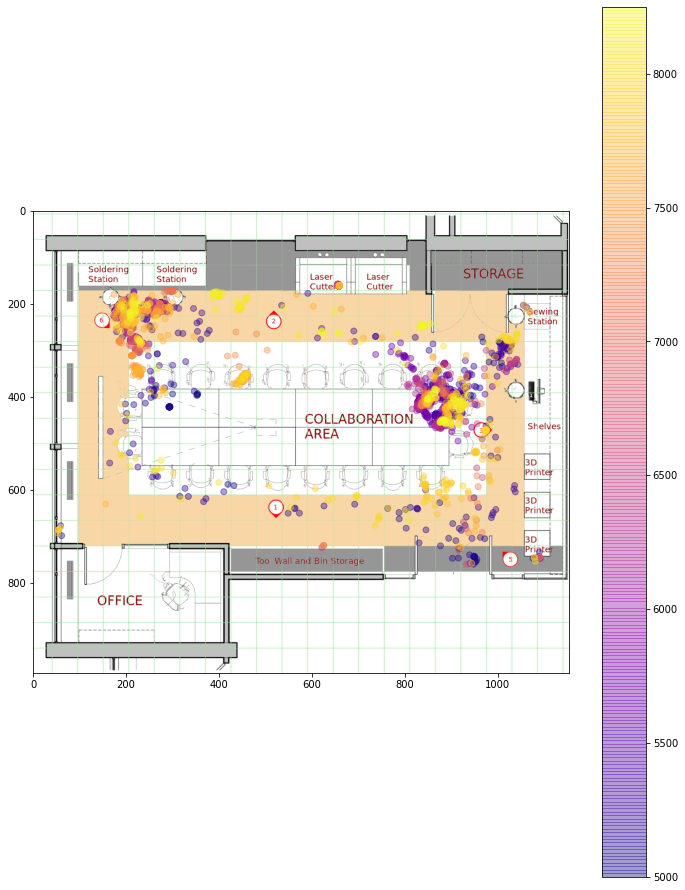

In [0]:
from matplotlib import cm
# load the image
floorplan = Image.open(EISfloorplan)
im_array = np.asarray(floorplan)

time1 = time.time()

# creat the graph
plt.figure(figsize=(12,16))
plt.imshow(im_array)
colors = sample.index[5000:]

plt.scatter(sample.Head_x_homography[5000:], sample.Head_z_homography[5000:], alpha = 0.4, c = colors, cmap = cm.plasma)      
plt.colorbar()

# function 
print('everything took %i sec' % ((time.time()-time1)))
        
plt.show()

In [0]:
sample.to_csv('./drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Collab Notebooks/Location in space/sample.csv')
value = 1
#pd.to_datetime(ksubset.timestamp[2])
ksubset = ksubset.reset_index()
ksubset.timestamp

0     2019-02-15 22:45:15
1     2019-02-15 22:45:16
2     2019-02-15 22:45:18
3     2019-02-15 22:45:21
4     2019-02-15 22:45:24
5     2019-02-15 22:45:27
6     2019-02-15 22:45:28
7     2019-02-15 22:45:30
8     2019-02-15 22:45:33
9     2019-02-15 22:45:34
10    2019-02-15 22:45:45
11    2019-02-15 22:45:51
Name: timestamp, dtype: object

In [0]:
len(kIDs)
pd.to_datetime(sample.timestamp[1]) - pd.to_datetime(sample.timestamp[0])

#ksubset = df[df.person_id == kIDs[0]]
for value in range(len(ksubset)):
  print(value, len(ksubset))
  if value < len(ksubset)-1:
    print(pd.to_datetime(ksubset.timestamp[value+1]) - pd.to_datetime(ksubset.timestamp[value]))

0 12
0 days 00:00:01
1 12
0 days 00:00:02
2 12
0 days 00:00:03
3 12
0 days 00:00:03
4 12
0 days 00:00:03
5 12
0 days 00:00:01
6 12
0 days 00:00:02
7 12
0 days 00:00:03
8 12
0 days 00:00:01
9 12
0 days 00:00:11
10 12
0 days 00:00:06
11 12


In [0]:
 import datetime
pd.to_datetime(sample.timestamp[1]) - pd.to_datetime(sample.timestamp[0]) > datetime.timedelta(minutes = 15)

extended_periods = np.zeros(len(sample))
extended_periods[0:10] = 1
extended_periods

array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
# function to calculate euclidean distance 

time_between_points = []
threshold = datetime.timedelta(minutes = 15)
m30 = datetime.timedelta(minutes = 30)

kIDs = list(set(df.person_id)) 
for k in kIDs:
  temp = []
  i = 0 
  ksubset = df[df.person_id == k].reset_index()
  if len(ksubset) > 50:
    
    for index in range(len(ksubset)):
      if index < len(ksubset)-1:
        gap = pd.to_datetime(ksubset.timestamp[index+1]) - pd.to_datetime(ksubset.timestamp[index])
        temp.append(gap)
        
        if gap > threshold:
          if pd.to_datetime(ksubset.timestamp[index]) - pd.to_datetime(ksubset.timestamp[i]) > m30:
            extended_periods[i:index] = 1

  time_between_points.append(temp)

time_between_points
    





[[],
 [],
 [],
 [],
 [],
 [],
 [Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:05'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:05'),
  Timedelta('0 days 00:00:01'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:04'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:10'),
  Timedelta('0 days 00:00:02'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:06'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:03'),
  Timedelta('0 days 00:00:01'),
  Timedelt

In [0]:
extended_periods.sum()

805.0

* Where there seats to work solo on on the far side of the wall?
* Current definition: for a given person, if they have a stretch of time longer than 30 minutes where more than 90% of it is spent on the collaborative area, I categorize this as solo_work. 
* I think 'y' is actually the height. Not z. Z is lateral position. 
* Has steph done this?

    def get_total_movement_per_person(df): 
      kIDs = list(set(df.person_id)) 
      for k in kIDs:
        ksubset = df[df.person_id == k]
        get_distance_at_every_point_then_do_map_distance()
